<a href="https://colab.research.google.com/github/parkhyeonseung/deep_basic/blob/main/3_4_myself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
drive.mount('/content/drive')


## MNIST 

In [ ]:
import numpy as np
import pickle
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt

def get_data():
    (x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.reshape(10000,-1)
    x_test = x_test.astype('float32') / 255. #normalize 데이터를 0과 1사이로
    return x_test, t_test

def init_network():
    with open("/content/drive/MyDrive/Colab Notebooks/sample_weight.pkl", 'rb') as f: #저장된 wieght파일을 불러와 model에 적용
        network = pickle.load(f)
    return network

def sigmoid(x):
  return 1/(1+np.exp(-x))

def softmax(a):
    c = np.max(a) # list a 중 가장 큰 값
    exp_a = np.exp(a-c)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    return y

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3'] #위와 같은 3층 layer 구현
    b1, b2, b3 = network['b1'], network['b2'], network['b3']

    a1 = np.dot(x, W1) + b1     #(10000, 784)(784, 50)  => (10000, 50)
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2    # (10000, 50)(50, 100)  => (10000, 100)
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3    # (10000, 100)(100, 10) => (60000,10)
    y = softmax(a3)
    return y

x, t = get_data()
network = init_network()

accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p= np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if p == t[i]:
        accuracy_cnt += 1

print("Accuracy:" + str(float(accuracy_cnt) / len(x)))
print(x[0].shape)

Accuracy:0.9352
(784,)


## Two Layer Network class

In [ ]:
import numpy as np
import pickle
from google.colab import drive
import tensorflow as tf
import matplotlib.pyplot as plt

class TwoLayerNet:
    # 초기화를 수행한다.
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
            np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * \
            np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def get_data(self):
        (x_train,t_train),(x_test,t_test) = tf.keras.datasets.mnist.load_data()
        t_train=tf.keras.utils.to_categorical(t_train)
        t_test=tf.keras.utils.to_categorical(t_test)
        x_train=x_train.reshape(60000,-1)
        x_test=x_test.reshape(10000,-1)
        return x_train,t_train,x_test, t_test

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def sigmoid_grad(self,x):
        return (1.0 - self.sigmoid(x)) * self.sigmoid(x)

    def softmax(self,x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T 

        x = x - np.max(x) # 오버플로 대책
        return np.exp(x) / np.sum(np.exp(x))

    def cross_entropy_error(self,y, t):
        if y.ndim == 1:
            t = t.reshape(1, t.size)
            y = y.reshape(1, y.size)
            
        # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
        if t.size == y.size:
            t = t.argmax(axis=1)
                
        batch_size = y.shape[0]
        return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

    # 예측(추론)을 수행한다.
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        #sigmoid 활성화함수
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)
       
        # softmax y의 확률값 
        return y

    # 손실 함수의 값을 구한다.
    # x : 입력데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        #결과의 확률값과 원핫인코딩된 값을 비교
        return self.cross_entropy_error(y, t)

    # 정확도를 구한다.
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # 가중치 매개변수의 기울기를 구한다.
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        a1 = np.dot(x, W1) + b1
        z1 = self.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = self.softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = self.sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)
        return grads    



train acc, test acc | 0.16271666666666668, 0.1582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


train acc, test acc | 0.8440666666666666, 0.8527



훈련데이터와 시험 데이터에 대한 정확도 추이


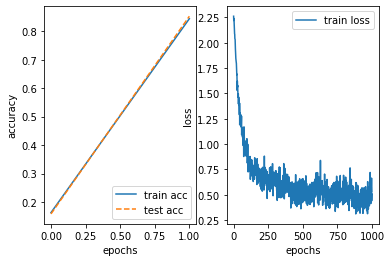

In [ ]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_train,t_train,x_test,t_test = network.get_data()

train_loss_list = []
train_acc_list = []
test_acc_list = []


# 하이퍼파라미터
iters_num = 1000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1
iter_per_epoch = max(train_size / batch_size, 1)


for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
print("\n\n\n훈련데이터와 시험 데이터에 대한 정확도 추이")
# 그래프 그리기
plt.subplot(1, 2, 1)
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()                   # 위
plt.show()